In [1]:
import torch
import torch.nn.functional as F
import network as model
import pytorch_lightning as pl
import wandb
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateLogger
from pytorch_lightning.loggers import WandbLogger
import os

In [2]:
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

In [3]:
pl.seed_everything(42)

42

In [4]:
wandb_logger = WandbLogger(project="video-colorization", tags=["colornet", "deeplab", "Test"],
                           name="Colornet 10.4 - Classification", log_model=True, group="Single Image Colorization with Classification")

In [5]:
# Hyperparameters
from argparse import ArgumentParser
parser = ArgumentParser(prog="image colorization")

# add model specific args
parser = model.ColorNet.add_model_specific_args(parser)

parser = pl.Trainer.add_argparse_args(parser)

# add PROGRAM level args
parser.set_defaults(train_dir="D:/Video Colorization/Datasets/Imagenet/CLS-LOC/train")
parser.set_defaults(test_dir="D:/Video Colorization/Datasets/Imagenet/CLS-LOC/test")

parser.set_defaults(patience=5)
parser.set_defaults(batch_size=12)
parser.set_defaults(learning_rate=4e-3)

parser.set_defaults(max_epochs=200)
parser.set_defaults(gpus=[1])
parser.set_defaults(logger=wandb_logger)
parser.set_defaults(deterministic=False)
parser.set_defaults(benchmark=True)
parser.set_defaults(log_save_interval=1000)
parser.set_defaults(accumulate_grad_batches=5)
parser.set_defaults(gradient_clip_val=1.0)
parser.set_defaults(auto_scale_batch_size=None)
parser.set_defaults(auto_lr_find=False)
parser.set_defaults(terminate_on_nan=True)
parser.set_defaults(weights_summary='top')

parser.set_defaults(train_percent_check=1.0)
parser.set_defaults(resume_from_checkpoint="checkpoints/checkpoint_epoch=021-val_loss=50919525786818239700909686784.0000.ckpt")

parser.set_defaults(profiler=None)
parser.set_defaults(fast_dev_run=False)

hparams = parser.parse_args([])
print(hparams)

Namespace(accumulate_grad_batches=5, amp_level='O1', augmentation=True, auto_lr_find=False, auto_scale_batch_size=None, auto_select_gpus=False, batch_size=12, benchmark=True, check_val_every_n_epoch=1, checkpoint_callback=True, default_root_dir=None, deterministic=False, distributed_backend=None, early_stop_callback=False, fast_dev_run=False, gpus=[1], gradient_clip_val=1.0, learning_rate=0.004, log_gpu_memory=None, log_save_interval=1000, logger=<pytorch_lightning.loggers.wandb.WandbLogger object at 0x000001678E5BF048>, max_epochs=200, max_steps=None, min_epochs=1, min_steps=None, num_nodes=1, num_processes=1, num_sanity_val_steps=2, num_tpu_cores=None, num_workers=6, overfit_pct=0.0, patience=5, precision=32, print_nan_grads=False, process_position=0, profiler=None, progress_bar_callback=True, progress_bar_refresh_rate=1, reload_dataloaders_every_epoch=False, replace_sampler_ddp=True, resume_from_checkpoint='checkpoints/checkpoint_epoch=021-val_loss=50919525786818239700909686784.0000

In [6]:
colornet = model.ColorNet(hparams)
#colornet = colornet.load_from_checkpoint(checkpoint_path="checkpoints/checkpoint_epoch=004-val_loss=6050.4106.ckpt")
#colornet.load_state_dict(torch.load("checkpoints/weights.pth"))

In [7]:
wandb_logger.watch(colornet, log=None, log_freq=1000)
checkpoint_callback = ModelCheckpoint(filepath="checkpoints/checkpoint_{epoch:03d}-{val_loss:.4f}", save_top_k=-1)
early_stopping = EarlyStopping("val_loss", patience=8)
lr_logger = LearningRateLogger()
trainer = pl.Trainer.from_argparse_args(hparams, checkpoint_callback=checkpoint_callback, callbacks=[lr_logger])

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [1]


D:\Anaconda\envs\colorization\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: UserWarning: warning, `hparams` dropped from checkpoint. An attribute is not picklable Can't pickle local object 'TorchGraph.hook_torch_modules.<locals>.backward_hook'
  warnings.warn(*args, **kwargs)

  | Name    | Type               | Params
-------------------------------------------
0 | network | DeepLabV3Plus      | 41 M  
1 | f_loss  | CrossEntropyLoss2d | 0     


D:\Anaconda\envs\colorization\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


0.003981071705534969


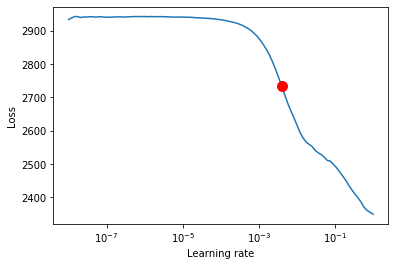

In [8]:
lr_finder = trainer.lr_find(colornet, early_stop_threshold=None)
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print(new_lr)

In [8]:
trainer.fit(colornet)


  | Name    | Type               | Params
-------------------------------------------
0 | network | DeepLabV3Plus      | 41 M  
1 | f_loss  | CrossEntropyLoss2d | 0     


Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [9]:
torch.save(colornet.state_dict(), "checkpoints/weights2.pth")